<a href="https://colab.research.google.com/github/HyeongChanHam/hand_project/blob/master/topic_2%20%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision - Final Project

* Team member
  - 함형찬 (20171263)
  - 이도경 (20141736)
  - 김민제 (20171036)

## Setting for colab

- If running environment is google colab, set env variable as 'colab'
- else (running at local), set env variable to others

In [1]:
env = 'colab'
if env=='colab':
    from google.colab import drive
    drive.mount('/content/drive')
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

Mounted at /content/drive


In [2]:
import os
import torch
import numpy as np
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import svm, metrics
import torch.nn as nn
import torch
import torch.nn.functional as F
from glob import glob
import pandas
import itertools

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
categories = ['rock', 'scissors', 'paper']

## concatenate hand heatmap extractor (from assignment 2) with classification FC layers.


In [4]:
class CPM2DPose(nn.Module):
    def __init__(self):
        super(CPM2DPose, self).__init__()
        
        self.scoremap_list = []
        self.layers_per_block = [2, 2, 4, 2]
        self.out_chan_list = [64, 128, 256, 512]
        self.pool_list = [True, True, True, False]

        self.relu = F.leaky_relu
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_1
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv4_3 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv4_4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv4_5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv4_6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv4_7 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv5_1 = nn.Conv2d(128, 512, kernel_size=1, stride=1, padding=0, bias=True)  # conv0_2
        self.conv5_2 = nn.Conv2d(512, 21, kernel_size=1, stride=1, padding=0, bias=True)  # conv0_2
        self.conv6_1 = nn.Conv2d(149, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv6_2 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv6_3 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv6_4 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv6_5 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv6_6 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, bias=True)  # conv0_2
        self.conv6_7 = nn.Conv2d(128, 21, kernel_size=1, stride=1, padding=0, bias=True)  # conv0_2
        self.conv7_1 = nn.Conv2d(149, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv7_2 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv7_3 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv7_4 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv7_5 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv7_6 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, bias=True)  # conv0_2
        self.conv7_7 = nn.Conv2d(128, 21, kernel_size=1, stride=1, padding=0, bias=True)  # conv0_2
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc_layer = nn.Sequential( # image -> semantic class로 나오도록
            nn.Linear(21*32*32,256),
            nn.ReLU(),
            nn.Linear(256,3)
        )
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.conv1_1(x))
        x = self.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2_1(x))
        x = self.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3_1(x))
        x = self.relu(self.conv3_2(x))
        x = self.relu(self.conv3_3(x))
        x = self.relu(self.conv3_4(x))
        x = self.maxpool(x)
        x = self.relu(self.conv4_1(x))
        x = self.relu(self.conv4_2(x))
        x = self.relu(self.conv4_3(x))
        x = self.relu(self.conv4_4(x))
        x = self.relu(self.conv4_5(x))
        x = self.relu(self.conv4_6(x))
        encoding = self.relu(self.conv4_7(x))
        x = self.relu(self.conv5_1(encoding))
        scoremap = self.conv5_2(x)

        x = torch.cat([scoremap, encoding], 1)
        x = self.relu(self.conv6_1(x))
        x = self.relu(self.conv6_2(x))
        x = self.relu(self.conv6_3(x))
        x = self.relu(self.conv6_4(x))
        x = self.relu(self.conv6_5(x))
        x = self.relu(self.conv6_6(x))
        scoremap = self.conv6_7(x)
        x = torch.cat([scoremap, encoding], 1)
        x = self.relu(self.conv7_1(x))
        x = self.relu(self.conv7_2(x))
        x = self.relu(self.conv7_3(x))
        x = self.relu(self.conv7_4(x))
        x = self.relu(self.conv7_5(x))
        x = self.relu(self.conv7_6(x))
        x = self.conv7_7(x)
        x = torch.flatten(x,1)
        x = self.fc_layer(x)
        return x

## DataLoader for hand images, labeling them as rock(0), scissors(1), paper(2)

In [5]:
class HandDataset(Dataset):
    def __init__(self, method=None):
        self.x_data = []
        self.y_data = []
        self.z_data = []
        self.root = '/content/drive/My Drive/hand_posture_data_mixed' # train: syn 300 + real 100, val: syn 150, test: real 20
        self.weight_root = self.root

        if method == 'train':
            self.root = self.root + '/train/' # self.root = drive/My Drive/hand_posture_data/train/

        elif method == 'val':
            self.root = self.root + '/val/' # self.root = drive/My Drive/hand_posture_data/train/

        else:
            self.root = self.root + '/test/' # self.root = drive/My Drive/hand_posture_data/test/

        rock_path = self.root + 'rock/'
        scissors_path = self.root + 'scissors/'
        paper_path = self.root + 'paper/'

        self.rock_img_path = sorted(glob(rock_path + 'rgb/*.jpg'))
        self.scissors_img_path = sorted(glob(scissors_path + 'rgb/*.jpg'))
        self.paper_img_path = sorted(glob(paper_path + 'rgb/*.jpg'))

        self.img_path = self.rock_img_path + self.scissors_img_path + self.paper_img_path

        for i in range(3):  # rock = 0, scissors = 1, paper = 2
          for j in range(len(self.img_path)//3):
            self.z_data.append(i)

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path[idx], cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))
        b, g, r = cv2.split(img)
        img = cv2.merge([r, g, b])

        transform1 = torchvision.transforms.ToTensor()
        new_x_data = transform1(img)

        return new_x_data, self.z_data[idx]

## Training class

In [15]:
class Trainer(object):
    def __init__(self, epochs, batch_size, lr):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = lr
        dataset = HandDataset(method='train')
        val_dataset = HandDataset(method='val')
        self.weight_root = dataset.weight_root # weight_root = drive/My Drive/hand_posture_data
        self._build_model()
        self.root = dataset.root # self.root = drive/My Drive/hand_posture_data/train/
        self.dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)
        self.val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

        print("Training...")

    def _build_model(self):
        # 2d pose estimator
        poseNet = CPM2DPose()
        self.poseNet = poseNet.to(device)
        self.poseNet.train()
        self.poseNet.load_state_dict(torch.load(self.weight_root+'/pretrained_weight.pth'), strict=False)
        for param in self.poseNet.parameters():
          param.required_grad = True
        print('Finish build model.')

    def skeleton2heatmap(self, _heatmap, keypoint_targets):
        heatmap_gt = torch.zeros_like(_heatmap, device=_heatmap.device)

        keypoint_targets = (((keypoint_targets)) // 8)
        for i in range(keypoint_targets.shape[0]):
            for j in range(21):
                x = int(keypoint_targets[i, j, 0])
                y = int(keypoint_targets[i, j, 1])
                heatmap_gt[i, j, x, y] = 1

        heatmap_gt = heatmap_gt.detach().cpu().numpy()
        for i in range(keypoint_targets.shape[0]):
            for j in range(21):
                heatmap_gt[i, j, :, :] = cv2.GaussianBlur(heatmap_gt[i, j, :, :], ksize=(3, 3), sigmaX=2, sigmaY=2) * 9 / 1.1772
        heatmap_gt = torch.FloatTensor(heatmap_gt).to(device)
        return heatmap_gt


    def heatmap2skeleton(self, heatmapsPoseNet):
        skeletons = np.zeros((heatmapsPoseNet.shape[0], heatmapsPoseNet.shape[1], 2))
        for m in range(heatmapsPoseNet.shape[0]):
            for i in range(heatmapsPoseNet.shape[1]):
                u, v = np.unravel_index(np.argmax(heatmapsPoseNet[m][i]), (32, 32))
                skeletons[m, i, 0] = u * 8
                skeletons[m, i, 1] = v * 8
        return skeletons

    def train(self):
        self.losses = list()
        self.val_losses = list()
        loss_func = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.poseNet.parameters(), self.learning_rate)
        
        for epoch in tqdm(range(self.epochs + 1)):
            """
            train
            """
            train_loss = 0
            for batch_idx, samples in enumerate(self.dataloader):
                optimizer.zero_grad()
                x_train, z_train = samples #z_train은 semantic class정보(rock=0/scissors=1/paper=2)

                x_train, z_train = x_train.to(device), z_train.to(device)

                pred = self.poseNet(x_train)

                loss = loss_func(pred, z_train)
                train_loss += loss.item()
                loss.backward()  # backpropagation
                optimizer.step() # update parameters

            self.losses.append(train_loss/batch_idx)

            """
            validation
            """
            val_loss = 0
            for batch_idx, samples in enumerate(self.val_dataloader):
                x_train, z_train = samples #z_train은 semantic class정보(rock=0/scissors=1/paper=2)

                x_train, z_train = x_train.to(device), z_train.to(device)

                pred = self.poseNet(x_train)

                loss = loss_func(pred, z_train)
                val_loss += loss.item()

            self.val_losses.append(val_loss/batch_idx)

            print('<Epoch {}>  |{:8.5}  /  {:6.5}  |  training loss / validation loss'.format(epoch, train_loss/batch_idx, val_loss/batch_idx))

        torch.save(self.poseNet.state_dict(), self.weight_root+'/_20_pretrained_weight.pth'.format(epoch))
        
        print('Finish training.')


## Testing class

In [7]:
class Tester(object):
    def __init__(self, batch_size):

        self.batch_size = batch_size
        dataset = HandDataset(method='test')
        self.CPM_weight_root = dataset.weight_root + '/_20_pretrained_weight.pth'
        self._build_model()
        self.root = dataset.root # self.root = drive/My Drive/hand_posture_data/test/
        self.dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

        self.datalen = dataset.__len__()

        print("Testing...")

    def _build_model(self):
        # 2d pose estimator
        poseNet = CPM2DPose()
        self.poseNet = poseNet.to(device)
        self.poseNet.eval()
        self.poseNet.load_state_dict(torch.load(self.CPM_weight_root))

    def skeleton2heatmap(self, _heatmap, keypoint_targets):
        heatmap_gt = torch.zeros_like(_heatmap, device=_heatmap.device) 

        keypoint_targets = (((keypoint_targets)) // 8)
        for i in range(keypoint_targets.shape[0]):
            for j in range(21):
                x = int(keypoint_targets[i, j, 0])
                y = int(keypoint_targets[i, j, 1])
                heatmap_gt[i, j, x, y] = 1

        heatmap_gt = heatmap_gt.detach().cpu().numpy()
        for i in range(keypoint_targets.shape[0]):
            for j in range(21):
                heatmap_gt[i, j, :, :] = cv2.GaussianBlur(heatmap_gt[i, j, :, :], ksize=(3, 3), sigmaX=2, sigmaY=2) * 9 / 1.1772
        heatmap_gt = torch.FloatTensor(heatmap_gt).to(device)
        return heatmap_gt 

    def test(self):
        correct = 0
        total = 0
        my_pred = []
        gt = []

        for batch_idx, samples in tqdm(enumerate(self.dataloader), total=len(self.dataloader)): 
            x_test, z_test = samples
            x_test, z_test = x_test.to(device), z_test.to(device)

            pred = self.poseNet(x_test)
            my_pred+=pred.argmax(dim=1).tolist()
            gt+=z_test.tolist()
            correct+=torch.sum(pred.argmax(dim=1)==z_test).item()
            total+=len(x_test)
            
        # now to get confusion matrix one can use the confusion_matrix
        # utility provided by sklearn
        conf_mat = confusion_matrix(gt, my_pred)

        # now it's time to plot the matrix
        # some standard matplotlib code
        # add a subplot
        fig = plt.figure()
        ax = fig.add_subplot(111)

        # plot the matrix
        cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)

        # add colorbar for reference
        fig.colorbar(cax)

        plt.xticks(np.arange(len(categories)), categories)
        plt.yticks(np.arange(len(categories)), categories)

        fmt = 'd'
        thresh = conf_mat.max() / 2.
        for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
            plt.text(j, i, format(conf_mat[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if conf_mat[i, j] > thresh else "black")

        # add labels to plot
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.savefig("Conf_Mat.jpg")
        plt.show()
        
        print("corrct: ",correct)
        print("total: ",total)
        print('Overall Accuracy: ', correct/total)
        self.overall_accuracy = correct/total



## Set training parameters

In [16]:
epochs = 40
batchSize = 8
learningRate = 1e-3
params = 'epoch: {} / batch_size: {} / learning_rate: {}'.format(epochs, batchSize, learningRate)

## Training

In [17]:
trainer = Trainer(epochs, batchSize, learningRate)
trainer.train()

Finish build model.
Training...


<Epoch 0>  |  2.9421  /  1.1171  |  training loss / validation loss
<Epoch 1>  |  2.9381  /  1.1152  |  training loss / validation loss
<Epoch 2>  |  2.9334  /  1.1131  |  training loss / validation loss
<Epoch 3>  |  2.9272  /  1.1099  |  training loss / validation loss
<Epoch 4>  |  2.9181  /  1.1052  |  training loss / validation loss
<Epoch 5>  |  2.9038  /  1.0977  |  training loss / validation loss
<Epoch 6>  |  2.8783  /  1.0846  |  training loss / validation loss
<Epoch 7>  |  2.8268  /  1.0536  |  training loss / validation loss
<Epoch 8>  |  2.6974  /  0.97337  |  training loss / validation loss
<Epoch 9>  |  2.3847  /  0.81818  |  training loss / validation loss
<Epoch 10>  |  2.0283  /  0.71076  |  training loss / validation loss
<Epoch 11>  |  1.7794  /  0.64331  |  training loss / validation loss
<Epoch 12>  |  1.5363  /  0.58969  |  training loss / validation loss
<Epoch 13>  |  1.3024  /  0.49587  |  training loss / validation loss
<Epoch 14>  |  1.0897  /  0.50459  |  

## Plot training / validation losses

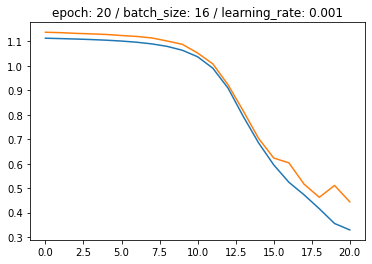

In [ ]:
plt.plot(trainer.losses, label='train_loss')
plt.plot(trainer.val_losses, label='val_loss')
plt.title("{}".format(params))
plt.show()

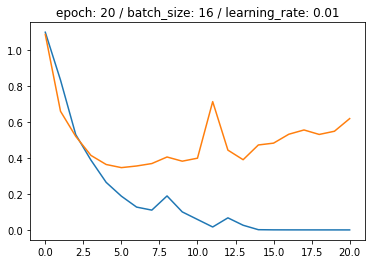

In [ ]:
plt.plot(trainer.losses, label='train_loss')
plt.plot(trainer.val_losses, label='val_loss')
plt.title("{}".format(params))
plt.show()

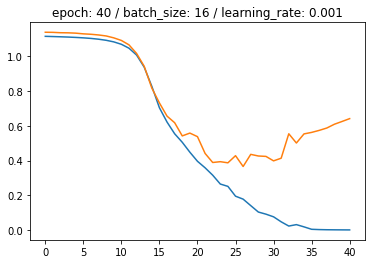

In [ ]:
plt.plot(trainer.losses, label='train_loss')
plt.plot(trainer.val_losses, label='val_loss')
plt.title("{}".format(params))
plt.show()

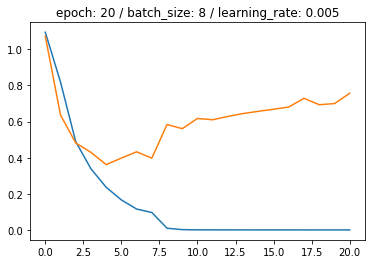

In [ ]:
plt.plot(trainer.losses, label='train_loss')
plt.plot(trainer.val_losses, label='val_loss')
plt.title("{}".format(params))
plt.show()

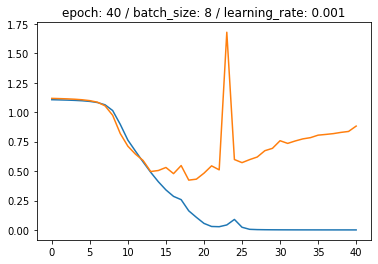

In [18]:
plt.plot(trainer.losses, label='train_loss')
plt.plot(trainer.val_losses, label='val_loss')
plt.title("{}".format(params))
plt.show()

## Evaluate trained model

Testing...


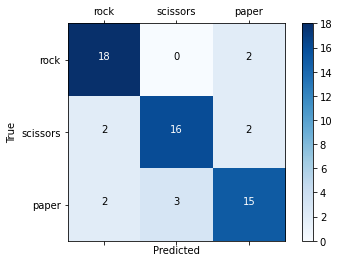

corrct:  49
total:  60
Overall Accuracy:  0.8166666666666667


In [14]:
# 20

tester = Tester(batchSize)
tester.test()

Testing...


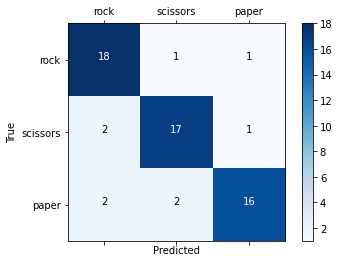

corrct:  51
total:  60
Overall Accuracy:  0.85


In [19]:
# 40
tester = Tester(batchSize)
tester.test()

## Result classification

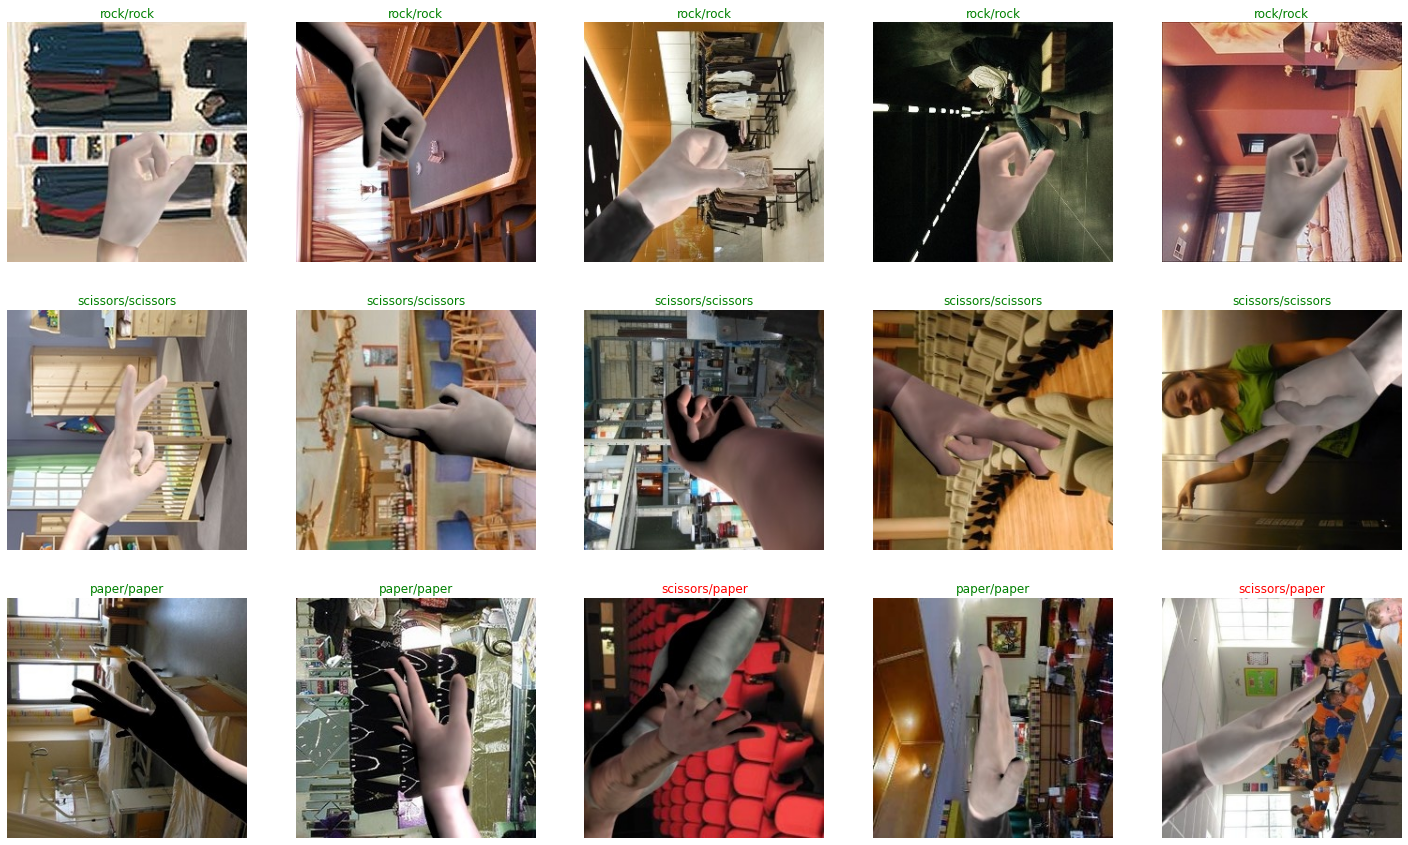

In [ ]:
num_figs=5
fig, ax = plt.subplots(3, num_figs)
fig.set_figwidth(num_figs*5)
fig.set_figheight(3*5)
for idx, cat in enumerate(categories):
    for fig_idx, fig in enumerate(range(num_figs)):
        axis = ax[idx, fig_idx]
        imgs = next(os.walk(os.path.join(tester.root, cat, 'rgb')))[2]
        one_img = np.random.choice(imgs, 1)[0]
        img_path = os.path.join(tester.root, cat, 'rgb', one_img)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        input = transform1(img)
        input = input.unsqueeze(dim=0).to(device)

        output = tester.poseNet(input)
        answer=output.argmax(dim=1)

        axis.imshow(img)
        title_obj = axis.set_title("{}/{}".format(categories[answer], cat))
        if categories[answer]==cat:
            plt.setp(title_obj, color='green')
        else:
            plt.setp(title_obj, color='red')
        axis.axis('off')
plt.show()

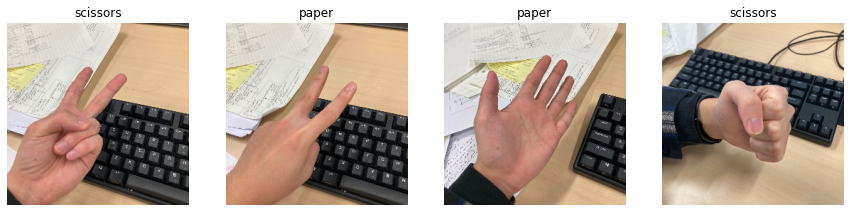

In [ ]:
fig, ax = plt.subplots(1,4)
fig.set_figwidth(15)
fig.set_figheight(7)
for i in range(4):
    img = cv2.imread('{}.jpg'.format(i+1), cv2.IMREAD_COLOR)
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    img = cv2.resize(img, (256,256))
    transform1 = torchvision.transforms.ToTensor()
    input = transform1(img)
    input = input.unsqueeze(dim=0).to(device)

    output = tester.poseNet(input)
    answer=output.argmax(dim=1)
    
    ax[i].imshow(img)
    ax[i].set_title(categories[answer])
    ax[i].axis('off')
plt.show()